In [85]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
def date_from_line(line):
    """returns DDMMYYYY from line in data file"""
    if int(line['Day'])<10:
        day='0'+str(line['Day'])
    else:
        day=str(line['Day'])
    if int(line[1])<10:
        month='0'+str(line['Month'])
    else:
        month=str(line['Month'])
    return day+month+str(line['Year'])

In [87]:
"""
    Creating list of all dates in the data
"""
dates=[]
for i in range(6,31):
    if i<10:
        dates.append('0'+str(i)+'112012')
    else:
        dates.append(str(i)+'112012')
for i in range(1,32):
    if i<10:
        dates.append('0'+str(i)+'012013')
    else:
        dates.append(str(i)+'012013')

In [88]:
with open("ordered_stop_lists/routes_and_stops.json") as file:  # reading dictionary {key:value} = {stop:[lat,long]}
    jpids_and_stops = json.load(file)

jpid='039A0001'
first_stop_id=int(jpids_and_stops[jpid][0]) # first stop on the route, this is known and will need to be found for each route

In [89]:
df=pd.read_csv("raw_data/"+jpid+".csv")

C:\Users\Conor\Anaconda3\envs\summer_project_windows_0_0.yml\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (21,27,29,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Initial data cleaning, dropping columns etc

In [90]:
# dropping unwanted columns - JourneyPatternID is constant
cols_to_drop=['JourneyPatternID','YearDay','LineID','Direction','TimeFrame','Operator','Congestion','Longitude','Latitude','BlockID','VehicleID','Dew Point (C)','Humidity (%)','Pressure (hPa)', 'Wind Direction','Gust Speed (km/h)','Precipitation','Events']
for col in cols_to_drop:
    df=df.drop(col,1)

In [91]:
# eliminating stops we don't believe to be on the route from the dataframe
df_removing_bad_stops=pd.DataFrame(columns=list(df))
for stop in jpids_and_stops[jpid]:
    df_removing_bad_stops=pd.concat([df_removing_bad_stops, df[df['StopID']==int(stop)]], ignore_index=True)
df=df_removing_bad_stops

In [92]:
# int values changed to int32, for memory purposes
df[['Year','Month','Day','Hours','Minute','Second','Timestamp','VehicleJourneyID','StopID','BusDelay','AtStop','Temperature (C)']]=df[['Year','Month','Day','Hours','Minute','Second','Timestamp','VehicleJourneyID','StopID','BusDelay','AtStop','Temperature (C)']].astype(np.int32)

In [97]:
# categorical
df[['WeekDay']]=df[['WeekDay']].astype(object)

In [93]:
df=df[abs(df['BusDelay'])<3600] # removing big outliers from the delay column before dropping (arbitrary cutoff choice of 1 hr chosen)

In [94]:
df=df[df['AtStop']==1] # removing non AtStop entries, only concerned with node to node model

In [95]:
df=df.drop('BusDelay',1)
df=df.drop('AtStop',1)

In [96]:
df=df[df['Hours']>6] # removing hours 0,1... to avoid errors associated with vjids spilling into next day

## Adding stop sequence number for every stop on each trip

In [98]:
df['StopSeq']="" # setting StopSeq to be an integer
for i in range(len(jpids_and_stops[jpid])):
    df.loc[df.StopID==int(jpids_and_stops[jpid][i]),'StopSeq']=i

## Ensuring only one occurrence of a bus stop on every instance of every route
## Creating column for the target feature, Cumulative Time Taken

In [99]:
"""
    Creating a dictionary with {key:value} as {DDMMYYYY:[vjids for date]}
"""
date_vjids={}
for date in dates:
    
    df_temp=df[df['Day']==int(date[:2])] # temporary dataframe containing only the entries on the given date
    df_temp=df_temp[df_temp['Month']==int(date[2:4])]
    df_temp=df_temp[df_temp['Year']==int(date[-4:])]
    
    date_vjids[date]=list(df_temp['VehicleJourneyID'].unique())

In [100]:
"""
    Creating a cleaned dataframe while adding in the target feature of Cumulative Time Taken
    CTT(stop) = time(arriving at stop) - time(leaving first recorded stop on trip)
    Removes multiple consecutive runs of bus stops on every route
"""
new_headings=list(df)
new_headings.append('Cumulative Time Taken')
df_cleaned=pd.DataFrame(columns=new_headings)

for date in dates:
    
    df_date=df[df['Year']==int(date[-4:])]
    df_date=df_date[df_date['Month']==int(date[2:4])]
    df_date=df_date[df_date['Day']==int(date[:2])]
    # df_date now contains only entries with the given date
    
    for i in range(len(date_vjids[date])):
        
        df_unique_trip=df_date[df_date['VehicleJourneyID']==date_vjids[date][i]]
        #df_unique_trip contains only entries relating to a given VJID on a given date
        
        unique_trip_data=df_unique_trip.values.tolist() # convert df to list for computation
        # list indexes:
        # Year=0,Month=1,Day=2,Hours=3,Minute=4,Second=5,WeekDay=6,Timestamp=7,VehicleJourneyId=8,StopID=9...
     
        if len(unique_trip_data)>2: # removing error case where only one line of data in vjid
                    
                first_recorded_stop=unique_trip_data[0][9] # First StopID in list

                j=0 # finding last occurrence of first recorded stop
                while j<len(unique_trip_data)-1 and unique_trip_data[j+1][9]==first_recorded_stop: # removing error case where only one stop occurs throughout the data in vjid
                    j+=1
                
                cleaned_unique_trip_data=[unique_trip_data[j]] # list with data of last occurrence of first recorded stop
                cleaned_unique_trip_data[0].append(0) # starting CTT of 0
                
                starting_timestamp=int(cleaned_unique_trip_data[0][7]) # used for CTT calculation for each stop

                for k in range(1,len(unique_trip_data)):
                        if unique_trip_data[k][9]!=unique_trip_data[k-1][9]: # new line added to result when bus hits a new stop
                            new_line=unique_trip_data[k]
                            new_line.append(int(new_line[7])-starting_timestamp) # adding cumulative time to reach new stop
                            cleaned_unique_trip_data.append(new_line)

                clean_trip_df=pd.DataFrame(cleaned_unique_trip_data,columns=new_headings)
                df_cleaned=pd.concat([df_cleaned, clean_trip_df], ignore_index=True)

In [101]:
df=df_cleaned # re-assigning new df as the df going forward

## Removing error case trips where StopSeq=0 and CTT!=0

In [102]:
a=df[df['StopSeq']==0]
a=a[a['Cumulative Time Taken']!=0]
a
invalid_trips={}
for index,row in a.iterrows():
    date=date_from_line(row)
    if date not in invalid_trips:
        invalid_trips[date]=[row['VehicleJourneyID']]
    else:
        invalid_trips[date].append(row['VehicleJourneyID'])

{}


In [103]:
for key in invalid_trips:
    for vjid in invalid_trips[key]:
        q=df[(df['Day']==int(key[:2])) & (df['Month']==int(key[2:4])) & (df['Year']==int(key[-4:])) & (df['VehicleJourneyID']==vjid)]
        df=df[~df.isin(q)].dropna()

## Putting trips without the known origin bus stop in a format suitable for modelling

In [104]:
"""
    Creating two dictionaries, both of which have a key of every date in the dataframe
    The first dictionary contains trips (vjids) that contain the known start point of the route
    The second dictionary contains trips (vjids) where the known starting point wasn't recorded
"""

date_vjids_with_start={} # key:value is date:[vjids containing stop 226]
date_vjids_without_start={} # key:value is date:[vjids NOT starting with stop 226]

for date in dates:
    
    df_temp=df[df['Day']==int(date[:2])] # temporary dataframe containing only the entries on the given date
    df_temp=df_temp[df_temp['Month']==int(date[2:4])]
    df_temp=df_temp[df_temp['Year']==int(date[-4:])]
    
    date_vjids_with_start[date]=list((df_temp[df_temp['StopID']==first_stop_id])['VehicleJourneyID'])
    
    date_vjids_without_start[date]=[]
    for vjid in date_vjids[date]:
        if vjid not in date_vjids_with_start[date]:
            date_vjids_without_start[date].append(vjid)


In [105]:
df_with_start, df_without_start=pd.DataFrame(columns=list(df)),pd.DataFrame(columns=list(df))

for date in dates:
    
    df_temp=df[df['Day']==int(date[:2])] # temporary dataframe containing only the entries on the given date
    df_temp=df_temp[df_temp['Month']==int(date[2:4])]
    df_temp=df_temp[df_temp['Year']==int(date[-4:])]

    for vjid in date_vjids_with_start[date]: # every trip with the start point
        df_new_with_trip=df_temp[df_temp['VehicleJourneyID']==vjid]
        df_with_start=pd.concat([df_with_start,df_new_with_trip], ignore_index=True) # concatenated with df_with_start
        
    for vjid in date_vjids_without_start[date]: # every trip with the start point
        df_new_without_trip=df_temp[df_temp['VehicleJourneyID']==vjid]
        df_without_start=pd.concat([df_without_start,df_new_without_trip], ignore_index=True) # concatenated with df_without_start

In [106]:
"""
    Creating a dictionary, {key:value} is {stop id : average CTT} for every stop in the dataframe containing
    routes with the known start point in them
"""
avg_ctt_for_stop_ids={}
for stop in jpids_and_stops[jpid]:
    # problem as bus route contains stops not on route
    avg_ctt_for_stop_ids[stop]=np.mean(df_with_start[df_with_start['StopID']==int(stop)]['Cumulative Time Taken'])

In [107]:
"""
    Creating a dictionary of dictionaries, storing the first recorded stop (that's not the known start stop) for
    each vjid on a given date
    Dictionary structure is { date : { vjid : first_recorded_stop } }
"""
#{date:{vjid:first_recorded_stop}}
start_point_for_date_vjid={}
for index, row in df_without_start.iterrows():
    date=date_from_line(row)
    if date not in start_point_for_date_vjid:
        start_point_for_date_vjid[date]={}
        start_point_for_date_vjid[date][row['VehicleJourneyID']]=row['StopID']
    else:
        if row['VehicleJourneyID'] not in start_point_for_date_vjid[date]:
            start_point_for_date_vjid[date][row['VehicleJourneyID']]=row['StopID']

In [108]:
"""
    Adding the average time from the origin to the first recorded stop on the routes not containing the known
    starting point
    This allows us to use trips whose first recorded stop wasn't the known starting point for modelling
"""
for index,row in df_without_start.iterrows():
    df_without_start.loc[index,'Cumulative Time Taken']=row['Cumulative Time Taken']+avg_ctt_for_stop_ids[str(start_point_for_date_vjid[date_from_line(row)][row['VehicleJourneyID']])]

In [109]:
# combining both dataframes for modelling
df_combined=pd.concat([df_with_start, df_without_start], ignore_index=True)

In [110]:
df=df_combined

## Data ready for modelling

In [111]:
df.to_csv('clean_data/'+jpid+'_clean.csv')

In [112]:
day_hour_ctt_avg={}
for i in range(7):
    temp_df=df[df['WeekDay']==i]
    day_hour_ctt_avg[i]=[]
    for j in range(7,24):
        hour_df=temp_df[temp_df['Hours']==j]
        day_hour_ctt_avg[i].append(np.mean(hour_df['Cumulative Time Taken']))

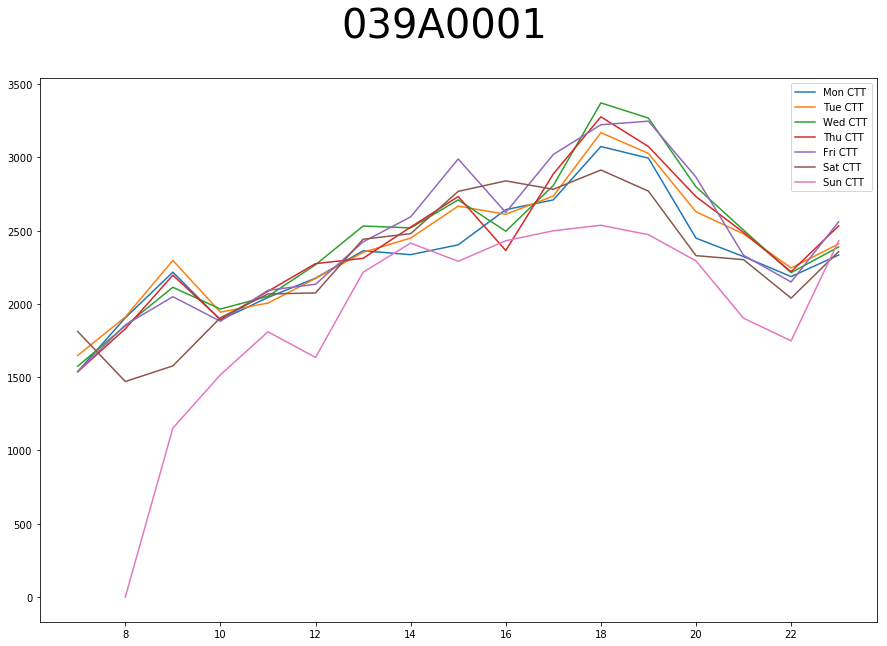

In [124]:
days=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
f=plt.figure(figsize=(15,10))
for key in day_hour_ctt_avg:
    plt.plot(range(7,24),day_hour_ctt_avg[key], label=str(days[key])+' CTT')
plt.suptitle(jpid, fontsize=40)
plt.legend()

f.savefig("clean_data/screenshots/"+jpid+"avg_ctt_by_hour_by_day.pdf")